# Visualization and explore the Wildfire data with Matplotlib, Pandas and Seaborn

This notebook will connect to a MySQL DB in the cloud which houses a combined table for wild
fires in the US and weather conditions during each fire. Independent features will be evaluated 
for collerlation and usefulness in a model. The goal of the model is to predict the fire intensity based on the fire features and the weather.

### Getting Started:
#### Importing the libraries 

In [1]:
%matplotlib inline
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

from sqlalchemy import create_engine   #sql engine

import yellowbrick as yb

import pylab as pl
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


import config #database connection variables 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler

### Connect to mySQL database in the cloud
The config files stored in the same directory as the notebook 
contains the connection information 

In [ ]:
# Skip this block if reading from disk

# create sqlalchemy engine
engine = create_engine("mysql+mysqlconnector://{user}:{password}@{host}/{dbname}"
                       .format(user=config.db_user,
                               password=config.db_pass,
                               dbname=config.db_main,
                               host=config.db_host))

### Query the machine learning table  
Setup the code to query the machine learning table in the database. Select all columns.


<i>Query the emissions and weather table until the final machine learning is setup. Limit the rows for initial exploration data</i>

In [ ]:
#Skip this block if reading from local disk

queryEmissions = """
SELECT *
FROM Emissions_Data
LIMIT 1000000;
"""

In [ ]:
#Skip this block if reading from local disk

#Execute Queries
dfEmissions = pd.read_sql(queryEmissions, engine)

#close the database connection
engine.dispose()

### Save the data to disk for faster access in the future
Store data in default data sub directory or folder

In [ ]:
#Save data to local disk

#Execute Queries
dfEmissions.to_csv('data/emissions1.csv', index = False)

### Read data from disk previously stored for faster access 

In [2]:
#Read the data from disk for faster access

#Read the data from disk for faster access
dfEmissions = pd.read_csv('data/emissions1.csv').sample(800000)

dfEmissions.head()

,Key,id,cluster_ref,lon,lat,year,doy,covertype,fuelcode,prefire_fuel,consumed_fuel,ECO2,ECO,ECH4,EPM2.5,fuel_moisture_class,BSEV,cwd_frac,duff_frac
85272,85273,93742,2008_236,-100.5062,32.1465,2008,213,2,2,673.524774,606.172297,1016.550941,42.432061,1.624542,6.182957,2.0,1.0,0.000000,0.000000
739963,739964,865548,2009_1352,-88.9070,30.7120,2009,51,3,1160,7020.760516,3902.227247,6532.328411,300.471498,8.780011,46.436504,2.0,4.0,0.013013,0.067773
874086,874087,1072005,2013_176,-116.7251,33.9049,2013,221,2,2,134.166942,120.750248,202.498166,8.452517,0.323611,1.231653,2.0,2.0,0.000000,0.000000
732703,732704,839896,2009_634,-122.0329,41.7174,2009,201,3,1220,4534.187262,3165.742015,4919.563091,421.043688,23.679750,72.178918,2.0,2.0,0.164887,0.275754
706678,706679,811700,2009_644,-118.5003,42.8463,2009,260,2,2,184.493556,166.044200,278.456124,11.623094,0.444998,1.693651,2.0,1.0,0.000000,0.000000


In [ ]:
print(dfEmissions.columns)

### Display the head of data for check.

### Analyze the features in the machine learning table

<i> This example uses emissions until the machine learning table is setup. We will predict BSEV 1-4) Burn serverity</i>

In [3]:
#drop columns which are not relevant 

#covertype maps to fuelcode so no need to have it twice
dfEmissions = dfEmissions.drop(columns=['cluster_ref', 'Key', 'id', 'year', 'covertype'])


In [4]:
#show the shape of the data
print (dfEmissions.shape)

#show the data by BSEV
print(dfEmissions.groupby('BSEV').count())



(800000, 14)
         lon     lat     doy  fuelcode  prefire_fuel  consumed_fuel    ECO2  \
BSEV                                                                          
1.0   151254  151254  151254    151254        151254         151254  151254   
2.0   476196  476196  476196    476196        476196         476196  476196   
3.0   125076  125076  125076    125076        125076         125076  125076   
4.0    47474   47474   47474     47474         47474          47474   47474   

         ECO    ECH4  EPM2.5  fuel_moisture_class  cwd_frac  duff_frac  
BSEV                                                                    
1.0   151254  151254  151254               151254    151254     151254  
2.0   476196  476196  476196               476196    476196     476196  
3.0   125076  125076  125076               125076    125076     125076  
4.0    47474   47474   47474                47474     47474      47474  


### Visualize home many of each type of dependent variables we have (1-4)

Use seaborn to plot a count histogram. We have 4 separate categories.
1 (not burned), 2 (light), 3(med), 4 (heavy burn)

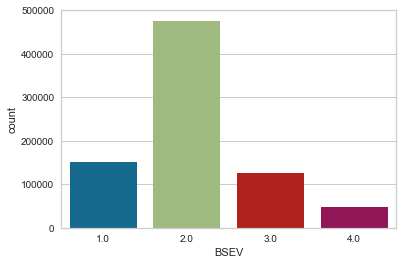

In [5]:
sns.countplot(dfEmissions['BSEV'],label="Count")
plt.show()

### Draw box diagram to see scale and quartiles of data
Data is on a very large scale with could affect some models scaling maybe needed.


In [ ]:
#draw box plot of see range of the data
import matplotlib
matplotlib.style.use('ggplot')
dfEmissions.plot(kind='box',figsize=(30,15))



### View histogram of all numerical data to better understand the distribution
Graphs show some data is continous while others are categorical. 
No normal distribution shown.Correlations can be seen between ECO/ECO2, EPM2.5/Consumed fuel

In [ ]:
#historgram of all numerical data
dfEmissions.hist(bins=30, figsize=(15,15))
pl.suptitle("Histogram for each numeric input variable")
plt.show()

### Scatter matrix plot for the continous values - categorical does not present much value
<i>once agains shows relationships between eco, eco2, ech4 consumed fuels. These features can likely be combined or dropped. Note this take a long time to run (minutes)</i> 

In [ ]:
#draw scatter matrix

#if you dropped features update the feature names
feature_names = ['ECH4', 'ECO', 'ECO2', 'EPM2.5', 'consumed_fuel', 'cwd_frac', 'duff_frac', 'prefire_fuel']


X = dfEmissions[feature_names]
y = dfEmissions['BSEV']
cmap = cm.get_cmap('gnuplot')
scatter = scatter_matrix(X, c = y, marker = 'o', s=40, hist_kwds={'bins':10}, figsize=(15,15), cmap = cmap)
plt.suptitle('Scatter-matrix for each input variable')


In [ ]:
print(dfEmissions.columns)

### Show which features likely have the most impact of Burn Serverity 
<i> Based on the data and this model fuel code, fuel mositure, lat, and lon are most predictive of burn serverity</i>

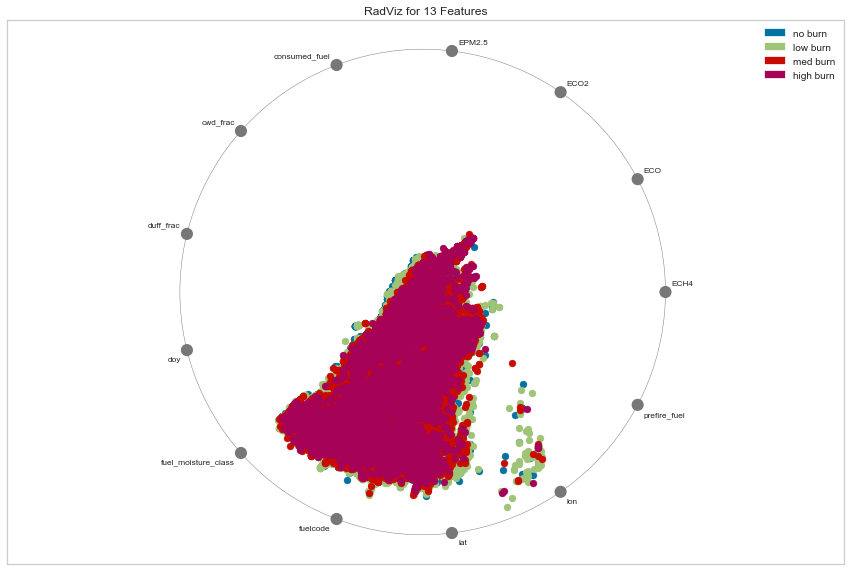

In [6]:
from yellowbrick.features import RadViz


#udpate the feature list if you removed features
feature_names = ['ECH4', 'ECO', 'ECO2', 'EPM2.5', 'consumed_fuel', 'cwd_frac', 'duff_frac','doy',
                 'fuel_moisture_class', 'fuelcode', 'lat', 'lon', 'prefire_fuel']
    

X = dfEmissions[feature_names]
y = dfEmissions['BSEV']
y = LabelEncoder().fit_transform(y)

# Specify the target classes
classes = ["no burn", "low burn", "med burn", "high burn"]

# Instantiate the visualizer
visualizer = RadViz(classes=classes, features=feature_names, size=(1080, 720))

 
visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)       # Transform the data
visualizer.show()              # Draw the data

### Show Random forest classier of the most important features to predict severity

<i> Lat/Lon and emissions are high important but not the covertype and fuel moisture type. I suspect this is because
scaling is not sued and those value types are very small and close together. I get different answers eveytime I run this but a random decision tree? Top and bottom half are consistent though. Run 3-4 times to get a feel </i>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features import FeatureImportances

model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(model, labels=feature_names, size=(1080, 720))

viz.fit(X, y)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.show()

### Visualize using rank 2D
<i> This shows a high digree of multicollinearity. Columsn can likely be combined or dropped </i>

In [ ]:
from yellowbrick.features import Rank2D

# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson', features=feature_names, size=(1080, 720))

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()



    

In [ ]:

#udpate the feature list if you removed features
feature_names = [ 'ECO2', 'duff_frac','doy',
                 'fuel_moisture_class', 'fuelcode', 'lat', 'lon', 'prefire_fuel']

X = dfEmissions[feature_names]
y = dfEmissions['BSEV']
y = LabelEncoder().fit_transform(y)
# Instantiate the visualizer with the Pearson ranking algorithm
visualizer1 = Rank2D(algorithm='pearson', features=feature_names, size=(1080, 720))

visualizer1.fit(X, y)
visualizer1.transform(X)
visualizer1.show()

### After analysis remove features deemed not releveant or duplicative  
Store the data for ML models or/and return the evaluations with the new ML data.

In [ ]:
#wrangle the data based on insights and save a clean ML CVS for the models

#simplfy the data by dropping features that have high Multicollinearity
""" 
dfEmissions = dfEmissions.drop(columns=['ECO', 'consumed_fuel'])


dfEmissions.to_csv('data/emissions_ML.csv', index = False)
 """

In [7]:
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB


from yellowbrick.datasets import load_game
from yellowbrick.model_selection import LearningCurve

# Load a classification dataset
#X, y = load_game()
#udpate the feature list if you removed features
feature_names = [ 'ECO2', 'duff_frac','doy',
                 'fuel_moisture_class', 'fuelcode', 'prefire_fuel']

# Encode the categorical data
X = dfEmissions[feature_names]
y = dfEmissions['BSEV']
y = LabelEncoder().fit_transform(y)

#X = OneHotEncoder(categories="auto").fit_transform(X)
#X = StandardScaler().fit_transform(X) 

#X is throwing an error as negative  need to check

# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 5)

# Instantiate the classification model and visualizer
"""
model = MultinomialNB()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure
"""

"\nmodel = MultinomialNB()\nvisualizer = LearningCurve(\n    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4\n)\n\nvisualizer.fit(X, y)        # Fit the data to the visualizer\nvisualizer.show()           # Finalize and render the figure\n"

/Users/sandstone/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


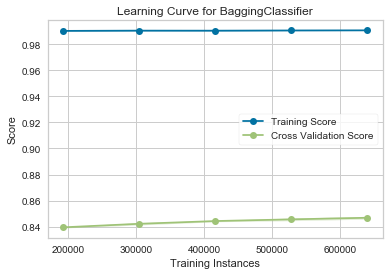

In [8]:
# Instantiate the classification model and visualizer

#udpate the feature list if you removed features
feature_names = ['ECO2', 'duff_frac','doy',
                 'fuel_moisture_class', 'fuelcode', 'lat', 'lon', 'prefire_fuel']


X = dfEmissions[feature_names]
y = dfEmissions['BSEV']
y = LabelEncoder().fit_transform(y)


#X = OneHotEncoder(categories="auto").fit_transform(X)
#X = StandardScaler().fit_transform(X) 

model = BaggingClassifier()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [ ]:
# Instantiate the classification model and visualizer
model = RandomForestClassifier(n_estimators=25)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure


In [ ]:
model = AdaBoostClassifier()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure